# Flatiron Phase 5 Project

## Aaron Galbraith

https://www.linkedin.com/in/aarongalbraith \
https://github.com/aarongalbraith

### Submitted: November 20, 2023

## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[Evaluation](#Evaluation)**<br>
- **[Recommendations](#Recommendations)<br>**
- **[Further Inquiry](#Further-Inquiry)**<br>

# Business Understanding

In 2022 the US Supreme Court ruled in [Dobbs v. Jackson Women's Health Organization](https://www.supremecourt.gov/opinions/21pdf/19-1392_6j37.pdf) that the United States Constitution would no longer confer a right to abortion, leaving the legality of abortion timelines and procedures to the discretion of the individual states and territories. This brought an end to constitutionally enshrined abortion access after the 1973 ruling in [Roe v. Wade](https://tile.loc.gov/storage-services/service/ll/usrep/usrep410/usrep410113/usrep410113.pdf) had codified that right into law for roughly two generations. Both immediately and in the short time since the Dobbs decision, [many states have reduced access to abortion, and 14 states have banned abortion entirely](https://reproductiverights.org/maps/abortion-laws-by-state/). [Advocates for birth control access fear that new government controls could move beyond abortion and attempt to restrict birth control access as well](https://www.npr.org/2022/08/16/1117615628/abortion-birth-control-title-x-supreme-court-family-planning-planned-parenthood).

In the new reproductive environment created by this ruling, Americans who are concerned with family planning are showing greater interest in birth control options and are more likely to consume and practice the birth control methods (that remain legal) in greater numbers than before. Pfizer can capitalize on this trend by understanding public perceptions of the various methods and responding to these perceptions in their marketing.

In 2018, researchers Surya Kallumadi and Felix Gräßer at UC Irvine created the [UCI ML Drug Review Dataset](https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018/) after collecting reviews from [Drugs.com](https://www.drugs.com/) that users had written about various drugs between 2008 and 2017. A substantial portion of these reviews addressed birth control and emergency contraception drugs.

People often share similar sentiments with each other in online spaces such as [Reddit](https://www.reddit.com/r/birthcontrol/) and [Quora](https://www.quora.com/search?q=birth%20control). Our project analyzes the Drug Review Dataset in order to 1) learn what the Dataset can tell Pfizer about sentiments toward the various methods of birth control and 2) train a model that can be applied in other online spaces to determine what birth control methods users are discussing and how they feel about them. With this tool, Pfizer can more effectively market their products to the increased demand created by the Dobbs ruling.

# Data Understanding

## Import files

In [1]:
do_grids = False

light_frame = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import cmudict

nltk.download('wordnet')
nltk.download('punkt')


from nltk.corpus import stopwords

import string
from wordcloud import WordCloud

import html

! pip install contractions
import contractions

import re

from IPython.display import display

import seaborn as sns

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, f1_score, roc_auc_score, log_loss

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


from pathlib import Path

SEED = 1979


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stubbletrouble/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stubbletrouble/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load and briefly explore data set

In [ ]:
url1 = 'https://raw.githubusercontent.com/aarongalbraith/flatiron-phase5-project/main/data/drugsComTrain_raw.tsv'
url2 = 'https://raw.githubusercontent.com/aarongalbraith/flatiron-phase5-project/main/data/drugsComTest_raw.tsv'

In [ ]:
d1 = pd.read_csv(url1, delimiter='\t', encoding='latin-1')
d2 = pd.read_csv(url2, delimiter='\t', encoding='latin-1')
df = pd.concat([d1,d2]).reset_index().drop(columns=['Unnamed: 0', 'index'])

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

There are some missing `condition` labels.

### `drugName` feature

In [ ]:
df.drugName.value_counts()

In [ ]:
df.drugName.value_counts().quantile(.90)

There are 3,671 unique drug names, and 10% of the drug names have more than 120 reviews.

In [ ]:
pd.set_option("display.max_rows", None)
print(df.drugName.value_counts())
pd.set_option("display.max_rows", 60)

A casual overview of the drug names indicates that they all seem valid. Some seem to specify drug combinations and/or dosage amounts.

### `condition` feature

In [ ]:
df.condition.value_counts()

In [ ]:
df.condition.value_counts().quantile(.90)

There are 916 unique conditions, and 10% of the conditions have more than 332 reviews.

In [ ]:
pd.set_option("display.max_rows", None)
print(df.condition.value_counts())
pd.set_option("display.max_rows", 60)

Oddly, the condition labels often (always?) omit initial 'F' and terminal 'r'. We can isolate instances of the former by searching for conditions that start with a lower case letter.

We will eventually trim our records to a number of conditions that Planned Parenthood specializes in treating (and perhaps birth control exclusively), but we will need all the records to help us determine missing condition labels. After we have restored (or discarded) all missing condition labels, we can drop the conditions outside the scope of this review.

### `drugName` × `condition` features

In [ ]:
df.groupby('drugName').condition.nunique().value_counts()[:10]

This means that, for example, 1869 drugs treat 1 condition only, etc.

In [ ]:
df.groupby('condition').drugName.nunique().value_counts()[:10]

This means that 188 conditions are treatable by two drugs, etc.

### `review` feature

In [ ]:
df.review.nunique()

This suggests that just over half of the review values are unique. Almost certainly there will be some duplication issues to deal with.

Let's look at several reviews.

In [ ]:
for i in range(5):
    print(df.review[i], '\n-----')

There appear to be escaped characters (e.g. `&#039;`, indicating an apostrophe) and contractions. We can address this now without affecting our analysis.

We'll reset the review texts to unescape these characters and expand all contractions.

Note: This will replace all instances of `ain't` with `are not`, resulting in some subject-verb agreement issues (e.g. `I are not`). This difference will be negligible in our analysis.

In [ ]:
df.review = df.review.apply(lambda x: contractions.fix(html.unescape(x)))

### `rating` feature

In [ ]:
df.rating.value_counts()

In [ ]:
df.rating.hist(bins=df.rating.nunique());

Most of the conditions lie at the extremes, and more of them appear to be at the positive extreme.

### `date` feature

In order to get a better understanding of the `date` feature, we'll convert it to a `datetime` object.

In [ ]:
df['datetime'] = df.date.apply(lambda x: datetime.strptime(x, '%B %d, %Y'))

In [ ]:
df.datetime.hist(bins=80);

In [ ]:
start_date = df.datetime.min().strftime('%B %d, %Y')
end_date = df.datetime.max().strftime('%B %d, %Y')

print('The reviews span specifically from', start_date+',', 'to', end_date+'.')

The reviews began to surge in early 2015.

### `usefulCount` feature

In [ ]:
usefulCountCumulative = list(df.usefulCount.values)
usefulCountCumulative.sort(reverse=True)

X = range(0,len(df),5000)
Y = []
for x in X:
    Y.append(sum(usefulCountCumulative[:x]))
fig, ax = plt.subplots()
ax.plot(X,Y);

(If all reviews were equally useful, this graph would be a straight diagonal line from SW to NE)

In [ ]:
df.usefulCount.value_counts()[:10]

# Data Preparation

## An outline for getting the information we need

In addition to the standard goals of data cleaning, the main goals of our data preparation are
1. Drop any records that don't pertain to birth control
2. Identify which method of birth control each review discusses

The records indicate a drug name and what condition (e.g. birth control) it treats, but problems with both of these features abound. There are many missing condition labels, and we can only restore them (and find out which ones should also have the "birth control" label) by understanding how they associate with the drug name labels. Some drug labels are for brand names, and others are for the generic or chemical name of the drug. Many records are actually instances of the review being entered twice, once with the brand name and once with the generic name. That's not the end of the complications, but it will suffice for an overview.

Once the first main goal is achieved and we are able to trim the records to only those that concern the condition of birth control, we can use the edited and matched brand/generic names to identify the birth control method each drug is an instance of (e.g. injectable, IUD, patch). This also involved, for example, consolidating certain versions of the same brand name together to reduce the number of brands and make for more tractable analysis.

## Missing and erroneous condition labels

In this section we will identify all `condition` labels that are either missing or in need of editing.

In [ ]:
len(df[df.condition.isna()])

In [ ]:
df.condition.fillna('missing', inplace=True)

In [ ]:
len(df[df.condition == 'missing'])

We noticed another `condition` label that was meant to indicate missing and should be accordingly changed.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' if 'Not Listed' in x else x)

In [ ]:
len(df[df.condition == 'missing'])

We've identified some actual missing `condition` labels, but we noticed there are more `condition` labels that seem suspicious, particularly ones that start with something other than an upper case character. Let's look at all such `condition` labels.

In [ ]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

These fall into three categories:
1. "X users found this comment helpful" should be regarded as an erroneous label and retagged as "missing.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' if 'users found' in x else x)

In [ ]:
len(df[df.condition == 'missing'])

2. Labels that show a clipped copy of the `drugName` label and end with a parenthesis should also be regarded as missing. These erroneous labels merely repeat information already available in the `drugName` feature.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x[-1] in ['(', ')'] \
                                  else x)

In [ ]:
len(df[df.condition == 'missing'])

3. Other `condition` labels appear to omit the first and/or last several characters. We can infer certain corrections here to restore many of the conditions.

In [ ]:
def condition_restore(condition):
    if condition.split()[-1] in ['Disorde', 'eve', 'Shoulde', 'Cance']:
        condition = condition+'r'
    if condition.split()[0] in ['acial', 'ibrocystic', 'ungal', 'amilial', 'ailure', 'ever', \
                                'emale', 'unctional', 'actor', 'ibromyalgia', 'atigue']:
        condition = 'F'+condition
    if condition.split()[0] in ['llicular', 'llicle', 'lic', 'cal']:
        condition = 'Fo'+condition
    if condition.split()[0] in ['mance']:
        condition = 'Perfor'+condition
    if condition.split()[0] in ['zen']:
        condition = 'Fro'+condition
    if condition.split()[0] in ['mis']:
        condition = 'Dermatitis Herpetifor'+condition
    return condition

df.condition = df.condition.apply(lambda x: condition_restore(x))

Let's look at what we have left.

In [ ]:
set(df[(~df.condition.str[0].isin(list(string.ascii_uppercase))) &
   (df.condition != 'missing')
  ].condition)

"von Willebrand's Disease" appears to be a naturally uncapitalized condition. The others have been impossible to restore and will also be regarded as missing.

In [ ]:
df.condition = df.condition.apply(lambda x: 'missing' \
                                  if x[0] not in list(string.ascii_uppercase) and \
                                  x.split()[0] != 'von' \
                                  else x)

In [ ]:
len(df[df.condition == 'missing'])

We will be able to restore more of these missing condition labels after we do some work with duplicates.

## Duplicates

In [ ]:
df.duplicated().value_counts()

In [ ]:
df[df.duplicated()]

In [ ]:
show_duplicates = True

def show_review(index):
    if show_duplicates:
        display(df[df.review == df.loc[index].review][['drugName', 'condition', 'rating', 'date', 'usefulCount']])
    print('\nReview #'+str(index),'| Rating:',df.loc[index].rating,'| Upvotes:',
          df.loc[index].usefulCount,'\n\n'+df.review.loc[index][1:-1])

In [ ]:
show_review(178703)

For reasons we will explore later, we believe this review was submitted twice by the same person, that each instance of it happened to receive 10 upvotes, and that it should correctly be associated with a grand total of 20 upvotes. Because this is one special instance where the review happened to receive 10 upvotes both times, making it a true duplicate of the data set, we will fix the values here, lest it interfere with operations later on.

In [ ]:
df.at[178703, 'usefulCount'] = 20
df.at[191001, 'usefulCount'] = 20
df.drop([131531, 143768], inplace=True)

## Duplicates due to brand / generic pairs

The main type of duplicate we should look out for is records with duplicate reviews, as those likely indicate some kind of actual erroneous duplication. Let's see how many of those there are.

In [ ]:
df.duplicated(subset=['review']).value_counts()

That's a lot!

Let's explore some facets of these duplicates.

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName']))])

The vast majority of duplicate reviews are accounted for by different drug names. Let's explore some examples.

In [ ]:
for ind in df[df.duplicated(subset=df.columns.difference(['drugName']))].index[:5]:
    show_review(ind)

These five examples make clear that the vast majority of duplicates are due to double-entry; (nearly) every review is entered once with its generic name and once with its brand name.

We can use this phenomenon to restore some of the missing condition labels. If a missing condition label is part of such a unique pair, then we can confidently assign it the condition of its pair-mate.

Let's broaden our search to records that duplicate every feature other than drug name and condition.

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))])

This is how many records are duplicates of other records in all values EXCEPT (POSSIBLY) drug name and condition. If a record is duplicated in this manner, the second (and third, fourth, etc.) instance will be captured in this bucket of dupes.

If we check only this bucket for dupes, we can see whether there are any triplets, etc.

In [ ]:
df_dupes = df[df.duplicated(subset=df.columns.difference(['drugName', 'condition']))]

In [ ]:
len(df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))])

There is only one.

In [ ]:
df_dupes[df_dupes.duplicated(subset=df_dupes.columns.difference(['drugName', 'condition']))]

In [ ]:
show_review(140144)

There are 6 records with the same review, date, rating, and condition. (The reviews on October 5, 2012, appear to be just a coincidence of the same review wording for a different drug and condition.) Because they're on the *same day*, it seems likely that these reviews were possibly entered repeatedly by the same person. The two with a useful count of 10 are likely a brand/generic pair.

As for the other 4, it's not clear what is going on. We will (would) later discover that there is also some discrepancy as to which of these is a brand or generic name. Since the review text isn't very descriptive, and the useful count is so low, (and it doesn't pertain to the main conditions treated by Planned Parenthood), let's just drop all 4.

In [ ]:
df.drop([60998, 119972, 133212, 140144], inplace=True)

Now we should be able to create a list of pairs of indices of records that match in all features except possibly drug name and condition. To make this run faster, we'll first create a way to sort them by date.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 11-12 s

# create stripped down dataframe that does not have drug names or conditions
# we don't need these features for this operation because we're checking for matches on all other features
df_pairs = df.drop(columns=['drugName', 'condition']).copy()

# create a list of indices of records that duplicate everything other than drug name and condition
df_dupes = df_pairs[df_pairs.duplicated()].index.tolist().copy()

# create and populate a dictionary whose keys are dates and whose values are indices
dates_dict = {}
# populate dictionary with keys that are dates belonging to the duplicates
for date_ in list(set(df[df.index.isin(df_dupes)].date.tolist())):
    dates_dict[date_] = []
# populate dictionary with values that are indices that are NOT from the duplicate list but DO share that date
for i in df[~df.index.isin(df_dupes)].index:
    dates_dict[df.loc[i].date].append(i)

Now we can use this dates dictionary to sort and identify the pairs.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 2–4 mins

# create a list of record pairs where each entry is a list of two indices
pairs = []

# iterate over the indices from the dupes list
for i in df_dupes:
    # set the date to the date from index i
    date_i = df.loc[i].date
    # iterate over OTHER indices who share that date
    for j in dates_dict[date_i]:
        # check for a match
        if df_pairs.loc[i].equals(df_pairs.loc[j]) and df.drugName.loc[i] != df.drugName.loc[j]:
            # remove this index from the dates dictionary so we have fewer to search through in later iterations
            dates_dict[date_i].remove(j)
            # add this pair to the pairs list
            pairs.append([i,j])
            break

Let's take a look at several of the pairs we've collected.

In [ ]:
pairs[:10]

Here we'll create a dictionary that matches the index of one pair member to the other member of the pair.

In [ ]:
pairs_dict = {}

for pair in pairs:
    for i in range(2):
        pairs_dict[pair[i]] = pair[1-i]

## Restore missing `condition` labels

We will restore missing `condition` labels in two ways, in order of certainty:

1. For missing values that possess a pair match, we will assign it the condition of its match.
2. For the remaining missing values, we will assign it the condition that is most commonly associated with its drug name.

In [ ]:
len(df[df.condition == 'missing'])

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 10-15 seconds

# iterate over each record pair
for pair in pairs:
    # iterate over each member of the pair
    for i in range(2):
        # identify a pair member whose condition is missing
        if df.loc[pair[i]].condition == 'missing':
            # assign to the pair member the condition of its pair-mate
            df.at[pair[i], 'condition'] = df.loc[pairs_dict[pair[i]]].condition

In [ ]:
len(df[df.condition == 'missing'])

Because it will be useful later, we'll make a feature that names the indicated drug and, if applicable, the paired drug.

This is not a *final* replacement for the drug name feature, but it will allow us to better recognize the relationship between the generic and brand drug names.

In [ ]:
%%time
# ⏰ record the time for this cell -- usually 15-30 seconds

df['ind'] = df.index

def drugList_fix(index, drugName_):
    drugList = [drugName_]
    if index in pairs_dict:
        drugList.append(df.loc[pairs_dict[index]].drugName)
        # alphabetize each drug pair so that we will not mistakenly duplicate e.g. [A,B] & [B,A]
        drugList.sort()
    return drugList

df['drugList'] = df.apply(lambda x: drugList_fix(x.ind, x.drugName), axis=1)

df.drop(columns='ind', inplace=True)

Now we can create a feature that tells us if a record is associated with a paired drug name or not.

In [ ]:
df['isPaired'] = df.drugList.apply(lambda x: True if len(x) > 1 else False)

In [ ]:
len(df[df.isPaired])

In [ ]:
len(df[~df.isPaired])

Because lists confuse certain operations

In [ ]:
df['drugSetString'] = df.drugList.apply(lambda x: x[0] + ' ' + x[1] if len(x) == 2 else x[0])

In [ ]:
len(df[df.duplicated(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']))])

With this new feature in place, we can drop one record from each of the brand/generic pairs. The drug name feature will retain only one member of the pair -- unpredictably either the brand or the generic -- which will make this feature more or less useless for the moment.

Before we drop these records, we'll create a bookmark copy of the dataframe.

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_1 = df.copy()

In [ ]:
# df = df_bookmark_1.copy()

In [ ]:
df.drop_duplicates(subset=df.columns.difference(['drugName', 'drugSet', 'drugList']), inplace=True)

Explain why we're doing the cell below.

In [ ]:
show_duplicates = False

For every remaining record with a missing condition, we will assign it the condition that is most common for the drug indicated by that record. (This will not be biased by duplicates from brand/generic pairs, because we have dropped those duplicates.)

This will be the last use we have for conditions *not* treated by Planned Parenthood.

In [ ]:
drugs_w_missing_condition = list(set(df[df.condition == 'missing'].drugSetString))

In [ ]:
len(drugs_w_missing_condition)

In [ ]:
df.drugSetString.nunique()

This applies to some 20% of the drugs. We'll create a dictionary that reports the most common condition for these drugs.

In [ ]:
%%time
# record the time for this cell -- 10-20 seconds

most_common_condition = {}

for drug in drugs_w_missing_condition:
    condition = df[df.drugSetString == drug].condition.value_counts().idxmax()
    if condition == 'missing' and len(set(df[df.drugSetString == drug].condition)) > 1:
        condition = df[(df.drugSetString == drug) &
                       (df.condition != 'missing')
                      ].condition.value_counts().idxmax()
    proportion = round(df[df.drugSetString == drug].condition.value_counts(normalize=True)[0],2)
    most_common_condition[drug] = [condition, proportion]

In [ ]:
most_common_condition['Sildenafil Viagra']

For example, if a review with an unlisted condition is about Viagra, we will assume the condition is Erectile 
Dysfunction.

In [ ]:
len(df[df.condition == 'missing'])

In [ ]:
df['condition'] = df.apply(lambda x: most_common_condition[x.drugSetString][0] \
                           if x.condition == 'missing' \
                           else x.condition, axis = 1)

In [ ]:
len(df[df.condition == 'missing'])

This is how many records there are that still have no condition label. This means the drugs indicated in these records are *only* indicated in references without an indicated condition. As such, there's not really anything we can do with these records, and we may as well drop them.

In [ ]:
df.drop(df[df.condition == 'missing'].index, inplace=True)

In [ ]:
len(df[df.condition == 'missing'])

## Drop records by condition

At this point, we still have more cleaning to do, but we have identified all the conditions that we can, and we won't have any further need for records with certain condition values, so we'll drop them.

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_2 = df.copy()

In [ ]:
# df = df_bookmark_2.copy()

Let's take another look at the complete list of conditions and choose which ones to keep.

In [ ]:
df.condition.nunique()

Since there are so many conditions to consider, let's limit this to just conditions with at least 25 reviews.

In [ ]:
pd.set_option("display.max_rows", None)
display(df['condition'].value_counts().loc[lambda x: x >= 25])
pd.set_option("display.max_rows", 60)

In [ ]:
df.drop(df[~df.condition.isin(['Birth Control', 'Emergency Contraception'])].index, inplace=True)

In [ ]:
df.condition.value_counts()

## Pairing generic and brand names

Now that we have a smaller number of records to deal with, we can sort out generic and brand names.

First we'll create a list of all values from the drug name feature. (Some of these have been dropped from the drug name feature itself when we dropped one record from each brand/generic pair, but all of them were included in the drug list feature.)

We'll create two lists: paired drugs (which we will attempt to sort into brand and generic) and single drugs (each of which we will then try to identify as either brand or generic).

In [ ]:
len(df)

In [ ]:
all_drug_lists = df.drugList.tolist()
all_drug_lists.sort()

In [ ]:
len(all_drug_lists)

In [ ]:
all_drug_names = set()

for list_ in all_drug_lists:
    all_drug_names.add(list_[0])
    if len(list_) > 1:
        all_drug_names.add(list_[1])

all_drug_names = list(all_drug_names)

all_drug_names.sort()

In [ ]:
len(all_drug_names)

In [ ]:
# this will create a full list with duplicates
# we need to do this intermediate before moving to the following step to remove duplicates
paired_drug_lists = df[df.isPaired].drugList.tolist()
paired_drug_lists.sort()

In [ ]:
len(paired_drug_lists)

In [ ]:
paired_drug_names = set()

for pair in paired_drug_lists:
    paired_drug_names.add(pair[0])
    paired_drug_names.add(pair[1])

paired_drug_names = list(paired_drug_names)

paired_drug_names.sort()

In [ ]:
unpaired_drug_names = [drug for drug in all_drug_names if drug not in paired_drug_names]

unpaired_drug_names.sort()

In [ ]:
len(paired_drug_names)

In [ ]:
len(unpaired_drug_names)

Together, these two lists of names constitute all the drug names left to sort into brand and generic categories.

In order to sort the list of paired drugs into brand and generic, we'll establish a dictionary whose keys are all the drug names that appear in a generic/brand pair.

In [ ]:
drug_dict = {}

for drug in paired_drug_names:
    drug_dict[drug] = set()

We'll assign values to those keys according to the pairings. For example, if drug name A is in a generic/brand pair with drug name B, then they will appear on each other's list of values in this dictionary.

In [ ]:
for pair in paired_drug_lists:
    drug_dict[pair[0]].add(pair[1])
    drug_dict[pair[1]].add(pair[0])

Let's find out how many of these drug names are associated with exactly one other drug name.

In [ ]:
len({drug for drug in drug_dict if len(drug_dict[drug]) == 1})

That should mean that exactly the remainder are associated with multiple drug names. It would make sense that drug names that belong to multiple generic/brand pairs are themselves the generic name. On that assumption, we'll create a list of generic drug names.

In [ ]:
generics = [drug for drug in drug_dict if len(drug_dict[drug]) > 1]

generics.sort()

In [ ]:
len(generics)

Now we'll check to make sure that the drug names we've just designated as "generic" do NOT belong to a generic/brand pair with *another* "generic".

In [ ]:
count = 0

for drug in generics:
    for match in drug_dict[drug]:
        if match in generics:
            count += 1

print(count)

Great.

Then we can begin designating drug names as "brands" if they are in a generic/brand pair with a generic.

In [ ]:
brands = set()

for generic in generics:
    for match in drug_dict[generic]:
        brands.add(match)

brands = list(brands)

brands.sort()

In [ ]:
len(brands)

Now let's see what drugs remain and how many records they are associated with.

In [ ]:
uncategorized = list(set(drug for drug in paired_drug_names if drug not in generics and drug not in brands))

uncategorized.sort()

To be clear, these are drug names with the following properties:

- the drug name belongs to an exclusive brand/generic pair
- we have not yet identified which members of the pair are brand and generic

In [ ]:
len(uncategorized)

We should be able to list all of these drug names in their pairs.

In [ ]:
repeated = set()
for drug in uncategorized:
    if drug not in repeated:
        print(drug, '||', list(drug_dict[drug])[0])
        repeated.add(drug)
        repeated.add(list(drug_dict[drug])[0])

With so few pairs, we can Google the names to determine which names of a pair are generic and brand names.

In [ ]:
new_brands = [
    'ParaGard', 'Natazia', 'NuvaRing', 'Necon 1 / 50', 'ella'
]

brands.extend(new_brands)

len(brands)

In [ ]:
for drug in new_brands:
    generics.append(list(drug_dict[drug])[0])

len(generics)

At this point, we have sorted all the paired brand and generic drug names. What remains is to identify whether each of the single drug names is a generic or brand name.

Let's look at them.

In [ ]:
unpaired_drug_names

Simple Google search confirms these are both generic names, so we'll add them as such.

In [ ]:
generics.extend(unpaired_drug_names)

generics.sort()

Now we create a more universal drug naming system whereby every record is identified with its generic name.

In [ ]:
def generic_fix(drugList):
    if len(drugList) == 1 or drugList[0] in generics:
        return drugList[0]
    else:
        return drugList[1]

df['genericName'] = df.drugList.apply(lambda x: generic_fix(x))

In [ ]:
def full_brand_fix(drugList):
    if len(drugList) == 1:
        return None
    elif drugList[0] in brands:
        return drugList[0]
    else:
        return drugList[1]

df['fullBrandName'] = df.drugList.apply(lambda x: full_brand_fix(x))

In [ ]:
brand_dict = {}

for fullName in brands:
    name = fullName
    tail = name.split()[-1]
    while tail.isnumeric() or tail in ['Fe', 'Lo', 'One-Step', '/', '1.5', 'Contraceptive']:
        name = name[:len(name)-len(tail)-1]
        tail = name.split()[-1]
    head = name.split()[0]
    while head in ['Lo', '/']:
        name = name[len(head)+1:]
        head = name.split()[0]
    brand_dict[fullName] = name

df['shortBrandName'] = df.fullBrandName.apply(lambda x: None if x == None else brand_dict[x])

## Duplicates due to multiple user entry

Now we'll turn to more possible duplicate instances. We suspect the same user has copy-pasted an identical review multiple times when that verbatim review appears for the same condition and (generic) drug name with the same rating. Let's look at all such instances.

In [ ]:
len(df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])])

In [ ]:
df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])] \
[['genericName', 'condition', 'review', 'rating', 'date']]

The review texts all appear to be unique. As long as the review and its duplicate appear close in time to one another (within days), then these should be collapsed into a single review with the respective useful counts added together.

First we'll check on the dates. The following cell will show the respective dates of when these duplicated reviews appeared.

In [ ]:
for ind in df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])].index:
    two_indices = list(df[df.review == df.loc[ind].review].index)
    print(df.loc[two_indices[0]].date, '... and ...', df.loc[two_indices[1]].date)

They're all identical dates except one that is a day apart.

We'll collapse these into single records and add the useful counts.

In [ ]:
for ind in df[df.duplicated(subset=['genericName', 'condition', 'review', 'rating'])].index:
    two_indices = list(df[df.review == df.loc[ind].review].index)
    x, y = two_indices[0], two_indices[1]
    count = int(df.loc[x].usefulCount + df.loc[y].usefulCount)
    df.at[x, 'usefulCount'] = count
    df.drop([y], inplace=True)

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_3 = df.copy()

In [ ]:
# df = df_bookmark_3.copy()

## Identifying birth control method

Consider redoing this, where you pass through everything one time and assign everything to its method (other than pill) and assign everything that remains to pill by default.

The problem with this would be the nonoxynol and the levonorgestrel. The former is a spermicide, which we're dropping because there are only two records. The latter we determined applied to emergency (not pill!) ... BUT what if there are brands associated with "the pill" that are also levonorgestrel? This might be worth investigating either way.

In [ ]:
birth_control_dict = {
    'IUD': ['Skyla', 'Mirena', 'Kyleena', 'Liletta', 'ParaGard'],
    'patch': ['Ortho Evra', 'Xulane'],
    'implantable': ['Implanon', 'Nexplanon'],
    'vaginal': ['NuvaRing'],
    'injectable': ['Depo-Provera', 'depo-subQ provera', 'Provera'],
    'emergency': ['Plan B', 'ella', 'Fallback Solo', 'Aftera', 'Take Action', 'Next Choice',
                       'My Way', 'EContra EZ'],
    'pill': ['Yasmin', 'Ortho Tri-Cyclen', 'Alesse', 'Aviane', 'Sprintec', 'Tri-Sprintec', 'Mircette',
             'Seasonique', 'Yaz', 'Lutera', 'Portia', 'Camila', 'Apri', 'Beyaz', 'Desogen', 'Kariva',
             'TriNessa', 'Zarah', 'Estarylla', 'Mononessa', 'Gianvi', 'Jolivette', 'Loestrin', 'Microgestin',
             'Ortho-Cyclen', 'Ortho-Novum', 'Necon', 'Femcon', 'Marlissa', 'Aubra', 'Viorele', 'Vestura',
             'Norlyda', 'Ortho Cyclen', 'Lybrel', 'Pirmella', 'Larin', 'Tarina', 'Previfem', 'Tri-Estarylla',
             'Lessina', 'Elinest', 'Cryselle', 'Ortho-Cept', 'Falmina', 'Altavera', 'Tri-Lo-Marzia', 'Taytulla',
             'CamreseLo', 'Philith', 'Dasetta', 'Gildess', 'Ovral', 'Jencycla', 'Tri-Linyah', 'Enskyce',
             'Orsythia', 'Sronyx', 'Velivet', 'Reclipsen', 'Nikki', 'Levlen', 'Loryna', 'Juleber', 'Trivora',
             'Zenchent', 'Tri-Previfem', 'Lyza', 'Seasonale', 'Mono-Linyah', 'Alyacen', 'Opcicon']
}

In [ ]:
def method_fix_1(shortBrandName):
    for method in birth_control_dict:
        if shortBrandName in birth_control_dict[method]:
            return method
    else:
        return None

df['method'] = df.shortBrandName.apply(lambda x: None if x == None else method_fix_1(x))

In [ ]:
generic_dict = {
    'patch': ['Ethinyl estradiol / norelgestromin'],
    'IUD': ['Copper'],
    'implantable': ['Etonogestrel'],
    'emergency': ['Ulipristal'],
    'vaginal': ['Ethinyl estradiol / etonogestrel'],
    'pill': ['Ethinyl estradiol / levonorgestrel',
             'Drospirenone / ethinyl estradiol / levomefolate calcium',  'Mestranol / norethindrone',
             'Ethinyl estradiol / norgestimate', 'Ethinyl estradiol / norethindrone',
             'Norethindrone', 'Drospirenone / ethinyl estradiol', 'Desogestrel / ethinyl estradiol',
             'Ethinyl estradiol / norgestrel', 'Ethinyl estradiol / folic acid / levonorgestrel',
             'Ethinyl estradiol / ethynodiol', 'Dienogest / estradiol'],
    'injectable': ['Medroxyprogesterone']
}

In [ ]:
def method_fix_2(generic):
    for method in generic_dict:
        if generic in generic_dict[method]:
            return method
    else:
        return None

df['method'] = df.apply(lambda x: method_fix_2(x.genericName) if x.method == None else x.method, axis=1)

In [ ]:
df[
    (df.method.isna())
].genericName.value_counts()

In [ ]:
for ind in df[df.genericName == 'Nonoxynol 9'].index:
    show_review(ind)

We could create a spermicide label, but there would only be two records for it, so we'll just drop them.

In [ ]:
df.drop([172606, 209857], inplace=True)

In [ ]:
for ind in df[
    (df.genericName == 'Levonorgestrel') &
    (df.method.isna())
].index[:10]:
    show_review(ind)

All of these examples describe emergency contraception.

In [ ]:
generic_dict['emergency'].append('Levonorgestrel')
df['method'] = df.apply(lambda x: method_fix_2(x.genericName) if x.method == None else x.method, axis=1)

In [ ]:
df[
    (df.method.isna())
].genericName.value_counts()

In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_4 = df.copy()

In [ ]:
# df = df_bookmark_4.copy()

# Exploration

## Rating over time

In [ ]:
# Calculate average rating for each method
average_ratings = df.groupby('method')['rating'].mean().reset_index()

# Create a bar chart using Seaborn
plt.figure(figsize=(14, 6))

# Set the font scale to increase text size
sns.set(font_scale=1.5)
sns.barplot(
    x='method',
    y='rating',
    data=average_ratings,
    order=average_ratings.sort_values('rating', ascending=False)['method'],
    palette='deep'
)
plt.xlabel('Method')
plt.ylabel('Average Rating')
plt.title('Average Rating for Each Birth Control Method')
plt.show()


In [ ]:
# Extract year from datetime
df['year'] = df['datetime'].dt.year

# Group by 'year' and 'method', calculate the average rating for each group
average_ratings = df.groupby(['year', 'method'])['rating'].mean().reset_index()

# Pivot the DataFrame to have 'method' as columns and 'year' as index
pivot_table = average_ratings.pivot_table(index='year', columns='method', values='rating')

# Plot the data
pivot_table.plot(kind='line', marker='o', figsize=(14, 6))
plt.title('Average Rating of Each Method by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Observations:
- Ratings generally declined after the number of ratings increased significantly in 2015.
- Emergency contraception has largely been more popular than other methods.
- IUDs, patches, and vaginal contraceptives tend to be more popular than pills and implantables.
- Injectable methods are consistently the least popular.

## Rating and upvotes

In [ ]:
# Count the occurrences of each rating
rating_counts = df['rating'].value_counts()

# Sort the index for better visualization
rating_counts = rating_counts.sort_index()

# Plotting the bar graph
plt.figure(figsize=(14, 6))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

Observations:
- There tend to be more positive ratings.
- Negative ratings are concentrated on the worst rating (1.0).
- There is a slight peak at 5.0. This indicates an attempt at neutrality.

In light of this distribution, we could recommend a 3-, 4-, or 5-point rating system that might be a better fit.

In [ ]:
rating_counts = [
    len(df[df.rating < 5]),
    len(df[df.rating == 5]),
    len(df[df.rating > 5])
]

# Plotting the bar graph
plt.figure(figsize=(6, 6))
plt.bar([0, 1, 2], rating_counts, color='skyblue')
plt.xticks([0, 1, 2], ['Negative', '5.0', 'Positive'])  # Setting custom tick labels
plt.xlabel(None)
plt.ylabel('Count')
plt.title('Distribution of Sentiment for All Birth Control Methods')
plt.show()

In [ ]:
methods = ['emergency', 'IUD', 'patch', 'vaginal', 'pill', 'implantable', 'injectable']

positive_counts, negative_counts = [], []

for method_ in methods:
    positive_counts.append(len(df[(df.method == method_) & (df.rating > 5)]))
    negative_counts.append(len(df[(df.method == method_) & (df.rating < 5)]))

total_counts = [pos + neg for pos, neg in zip(positive_counts, negative_counts)]

# Calculate percentages for positive and negative counts
positive_percentages = [pos / total * 100 for pos, total in zip(positive_counts, total_counts)]
negative_percentages = [neg / total * 100 for neg, total in zip(negative_counts, total_counts)]

# Plotting the grouped bar graph
bar_width = 0.35
index = range(len(methods))

plt.figure(figsize=(10, 6))

plt.bar(index, positive_percentages, bar_width, label='Positive', color='skyblue')
plt.bar([i + bar_width for i in index], negative_percentages, bar_width, label='Negative', color='salmon')

plt.xlabel('Birth Control Methods')
plt.ylabel('Percentage')
plt.title('Positive and Negative Sentiment Percentages for Each Birth Control Method')
plt.xticks([i + bar_width / 2 for i in index], methods)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
methods = ['emergency', 'IUD', 'patch', 'vaginal', 'pill', 'implantable', 'injectable', '**no method']
use_percentages = [0.1, 7.2, 0.1, 1.5, 15.6, 1.6, 2.4, 7.2]

colors = ['skyblue'] * (len(methods) - 1) + ['red']  # Set colors for each bar

plt.figure(figsize=(10, 6))

plt.bar(methods, use_percentages, color=colors)

plt.xlabel('Birth Control Methods\n\n**at risk for unintended pregnancy')
plt.ylabel('Use Percentage')
plt.title('Use Percentages of Different Birth Control Methods')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# Calculate average usefulCount for each rating
average_useful_count = df.groupby('rating')['usefulCount'].mean().reset_index()

# Create a bar chart using Seaborn
plt.figure(figsize=(14, 6))
sns.barplot(x='rating', y='usefulCount', data=average_useful_count, palette='viridis')
plt.xlabel('Rating')
plt.ylabel('Average Upvotes')
plt.title('Average Upvotes for Each Rating')
plt.show()

Observations:
- There is no real gain in usefulness other than for ratings 8 and above, which we saw earlier are also more prevalent than all other ratings except for 1.0, the lowest.

Let's look at only the top 20% most useful reviews.

In [ ]:
# Calculate average usefulCount for each rating
average_useful_count = df[df.usefulCount > df.usefulCount.quantile(.80)].groupby('rating')['usefulCount'].mean().reset_index()

# Create a bar chart using Seaborn
plt.figure(figsize=(14, 6))
sns.barplot(x='rating', y='usefulCount', data=average_useful_count, palette='viridis')
plt.xlabel('Rating')
plt.ylabel('Average Upvotes')
plt.title('Average Upvotes for Each Rating — Top 20% of Upvotes')
plt.show()

There's a relative spike among ratings of 3.0. Let's look at some highly upvoted reviews with a rating of 3.0.

In [ ]:
for ind in df[df.rating == 3].sort_values(by='usefulCount', ascending=False).index[:10]:
    show_review(ind)

Nothing jumps out about these reviews except that they are certainly negative and could all probably have been 1.0 ratings.

## Term frequency analysis

Explain motivation for cells below.

### Stop words

We need stop lists for different purposes.

For certain ngram analysis, we might like to consider keeping stop words like "no" and "not". This could be a "light" stop list.

In other cases, we really want to trim it down, and stop as many words as possible. This could be a "heavy" stop list.

Really need to clean up all stop list stuff.

In [10]:
punctuation_list = [char for char in string.punctuation]
punctuation_list.extend(['', '``', "''", '...'])

# obtain the standard list of stopwords
nltk.download('stopwords', quiet=True)
# start our own list of stopwords with these words
stop_list_heavy = stopwords.words('english')
# stop words to keep
# 44-59 be/have/do verbs
# 64-178 prepositions/subordinate conjunctions/modals
stop_list_light = stop_list_heavy.copy()
stop_list_light = stop_list_light[:44] + stop_list_light[60:64]
# add punctuation characters
for char in string.punctuation:
    stop_list_light.append(char)
    stop_list_heavy.append(char)
# add misc other tokens
stop_list_light.extend(['', 'll', 're', 've', 'ha', 'wa', '``', "''"])
stop_list_heavy.extend(['', 'll', 're', 've', 'ha', 'wa', '``', "''"])

### Create more usable versions of review feature

- `review_lower` will only make everything lower-case but not otherwise remove stop words, punctuation, or alter (lemmatize) anything.
- `review_simple` will be lemmatized and "lightly" stopped, keeping some be/have/do verbs as well as other modals, prepositions and negatives

The "heavy" stop list (and other stop lists) can be used to further trim down `review_simple` if desired.

NEED TO REVIEW THE REST OF THIS DOC TO EDIT INSTANCES OF STOP LISTS AND REVIEW_LOWER, ETC.

In [ ]:
df['review_lower'] = df.review.apply(lambda x: x.lower())

In [ ]:
df.review_lower.head()

## some functions

In [ ]:
# a function that takes a list of documents and 1) tokenizes them, 2) lemmatizes them, and 3) removes stopwords
# for example, to execute this function use make_tokens(df.review.tolist())
# IN: a list of documents // OUT: a list of tokens

lemmatizer = WordNetLemmatizer()

def make_tokens(docs_list, stop_list=stop_list_light):
    # join documents into a single string
    docs_joined = ' '.join(docs_list)
    # tokenize the single string into a list of tokens
    tokens = nltk.word_tokenize(docs_joined)
    # lemmatize the list of tokens
    tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    # stop the list of tokens
    tokens_stopped = [word for word in tokens_lemmatized if word not in stop_list]
    return tokens_stopped

### this section is dedicated to performing TFIDF in pairs (pos/neg) and displaying corresponding word clouds

In [ ]:
extra_stops= ['pill', 'month', 'control', 'birth', 'day', 'first', 'week', 'year', 'get', \
              'time', 'side', 'would', 'effect', 'like', 'never', '3', 'got', 'started', 'also', 'one', '2', \
              'feel', 'since', 'really', 'take', 'back', 'every', 'two', 'went', 'little', 'experience', \
              'even', 'put', 'recommend', 'taking', 'last', 'much', 'thing', 'almost', 'ever', 'going', 'far', \
              'getting', 'still', 'could', 'go', 'made', '4', 'took', 'lot', '5', 'felt', 'around', 'tried', \
              'three', 'using', 'say', 'second', 'mirena', 'skyla', 'iud', 'nuvaring', 'nuva', 'ring', 'use', \
              'thought', 'experienced', 'make', 'used', 'doe', 'implanon', 'nexplanon', 'alway', 'see', 'know', \
              'something', 'shot', 'always', 'depo', 'provera', 'away', 'injection', 'patch', 'xulane', 'third', \
              'ortho', 'evra', 'think', 'yaz', 'noticed', 'taken', 'implant', 'paragard', 'plan', 'b', 'period']

In [ ]:
%%time

method_tokens = {}

for method_ in df.method.unique():
    stop_list_ = stop_list_heavy.copy()
    stop_list_.extend(extra_stops)
    tokens = make_tokens(df[df.method == method_].review_lower.tolist(), stop_list_)
    method_tokens[method_] = {}
    method_tokens[method_]['positive'] = make_tokens(df[(df.method == method_) \
                                                        & (df.rating > 5)].review_lower.to_list(), stop_list_)
    method_tokens[method_]['negative'] = make_tokens(df[(df.method == method_) \
                                                        & (df.rating < 5)].review_lower.to_list(), stop_list_)

In [ ]:
def method_word_clouds(method_):

    positive_text = (' ').join(method_tokens[method_]['positive'])
    negative_text = (' ').join(method_tokens[method_]['negative'])

    documents = [positive_text, negative_text]

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)

    positive_tfidf_scores = tfidf_matrix[0]  # TF-IDF scores for positive document
    negative_tfidf_scores = tfidf_matrix[1]  # TF-IDF scores for negative document

    feature_names = vectorizer.get_feature_names_out()

    # Create dictionaries with words and their corresponding TF-IDF scores for each document
    positive_word_scores = dict(zip(feature_names, positive_tfidf_scores.toarray()[0]))
    negative_word_scores = dict(zip(feature_names, negative_tfidf_scores.toarray()[0]))

    # Generate word clouds for positive and negative documents
    positive_wordcloud = WordCloud(
        width=600,
        height=400,
        colormap='Greens',
        collocations=True
    ).generate_from_frequencies(positive_word_scores)
    negative_wordcloud = WordCloud(
        width=600,
        height=400,
        colormap='Reds',
        collocations=True
    ).generate_from_frequencies(negative_word_scores)

    # show positive and negative wordclouds for apple side by side
    fig, ax = plt.subplots(figsize=(32,16), ncols=2)
#     fig.subplots_adjust(top=0.85, bottom=0.15, hspace=0.3)
    ax[0].imshow(positive_wordcloud)
    ax[0].set_title('Positive Reviews', fontsize=65)
    ax[0].axis('off')
    ax[1].imshow(negative_wordcloud)
    ax[1].set_title('Negative Reviews', fontsize=65)
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
method_word_clouds('emergency')

In [ ]:
method_word_clouds('IUD')

In [ ]:
method_word_clouds('patch')

In [ ]:
method_word_clouds('vaginal')

In [ ]:
method_word_clouds('pill')

In [ ]:
method_word_clouds('implantable')

In [ ]:
method_word_clouds('injectable')

In [ ]:
for ind in df[(df.review_lower.str.contains('breast')) & \
   (df.method == 'patch')
  ].sort_values(by='rating', ascending=False).sort_values(by='usefulCount', ascending=False).index[:10]:
    show_review(ind)

————————————————————————————————————————————————————————————

### this section is work that may be retrieved and built upon to show individual word clouds

If anything, the most important words stuff should factor in the extra_stops and be incorporated in the function that produces the pairs of word clouds.

In [ ]:
%%time

reviews, corpus, tokens, tokens_joined = {}, {}, {}, {}

for method_ in df.method.unique():
    pos_join = ' '.join(method_tokens[method_]['positive'])
    neg_join = ' '.join(method_tokens[method_]['negative'])
    corpus[method_] = pos_join + ' ' + neg_join # the above as a single string with spaces
    tokens[method_] = nltk.word_tokenize(corpus[method_]) # the above as a list of words
    tokens_joined[method_] = ' '.join(tokens[method_]) # the above as a single string with spaces

tokens_joined_list = [tokens_joined[method_] for method_ in df.method.unique()]

In [ ]:
reviews, corpus, tokens, tokens_joined = {}, {}, {}, {}

for method_ in df.method.unique():
    reviews[method_] = df[df.method == method_].review_lower.tolist() # a list of all reviews of one method
    corpus[method_] = ' '.join(reviews[method_]) # the above as a single string with spaces
    tokens[method_] = nltk.word_tokenize(corpus[method_]) # the above as a list of words
    tokens_joined[method_] = ' '.join(tokens[method_]) # the above as a single string with spaces

tokens_joined_list = [tokens_joined[method_] for method_ in df.method.unique()]

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_list_heavy)
tfidf_matrix = tfidf_vectorizer.fit_transform(tokens_joined_list)

for i, doc in enumerate(tokens_joined_list):
    print(f"Important words in Document {i+1}:")
    feature_names = tfidf_vectorizer.get_feature_names_out()
    feature_index = tfidf_matrix[i, :].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
    top_words = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:10]  # Adjust 5 to desired number of top words
    for word_index, score in top_words:
        print(f"{feature_names[word_index]} (TF-IDF Score: {score:.2f})")
    print()


————————————————————————————————————————————————————————————

## What remains between here and the engineered features is of questionable use

In [ ]:
uv = list(df.usefulCount.values)
uv.sort(reverse=True)

for threshold in list(range(10, 100, 10)):
    n = 0
    while sum(uv[:n]) < threshold / 100 * df.usefulCount.sum():
        n += 1
    print(str(int(n * 100 / len(df)))+'%','of the reviews received', str(threshold)+'%', 'of all the upvotes.')
    print('This includes reviews with', uv[n], 'or more upvotes\n')

print('The remaining', str(100 - int(n * 100 / len(df)))+'%','of the reviews received', uv[n], 'or fewer upvotes \
and made up the remaining 10% of all the upvotes.')

In [ ]:
X = range(0,len(df),100)
Y = []
for x in X:
    Y.append(sum(uv[:x]))
fig, ax = plt.subplots()
ax.plot(X,Y);

This shows the cumulative sum of upvotes. For example, if we go 5% of the reviews in from the left on the x-axis, we would reach up to 33% of the total upvotes on the y-axis.

# feature engineering ideas to assist in modeling

In [ ]:
engineered_features = []

In [ ]:
def rating_plot(col, feature_name):

    # Grouping by 'rating' and calculating the mean of 'but_count' for each rating
    count_by_rating = df.groupby('rating')[col].mean()

    # Creating the bar chart
    plt.figure(figsize=(8, 6))
    count_by_rating.plot(kind='bar', color='skyblue')
    plt.title(f'Average {feature_name} for Each Rating')
    plt.xlabel('Rating')
    plt.ylabel(f'Average {feature_name}')
    plt.xticks(rotation=0)  # Rotate x-axis labels if needed
    plt.grid(axis='y')  # Add gridlines for better readability
    plt.tight_layout()
    plt.show()


## word count

In [ ]:
df['word_tokens'] = df.review_lower.apply(
    lambda x: [word for word in nltk.word_tokenize(x) if word not in punctuation_list])

In [ ]:
df['word_count'] = df.word_tokens.apply(lambda x: len(x))

In [ ]:
rating_plot('word_count', 'Word Count')

In [ ]:
engineered_features.append('word_count')

## character count

In [ ]:
df['character_count'] = df.review_lower.apply(lambda x: len(re.findall(r'\w', x)))

In [ ]:
rating_plot('character_count', 'Character Count')

In [ ]:
engineered_features.append('character_count')

## sentence count

In [ ]:
df['sentence_count'] = df.review_lower.apply(lambda x: len(sent_tokenize(x)))

In [ ]:
rating_plot('sentence_count', 'Sentence Count')

In [ ]:
engineered_features.append('sentence_count')

## Coleman-Liau Index

In [ ]:
df['CLI_readability'] = df.apply(
    lambda x: 5.88 * x.character_count / x.word_count - 29.6 * x.sentence_count / x.word_count - 15.8, axis=1)

In [ ]:
rating_plot('CLI_readability', 'CLI Readability')

In [ ]:
engineered_features.append('CLI_readability')

## Automated Readability Index

In [ ]:
df['ARI_readability'] = df.apply(
    lambda x: 4.71 * x.character_count / x.word_count + 0.5 * x.word_count / x.sentence_count - 21.43, axis=1)

In [ ]:
rating_plot('ARI_readability', 'ARI Readability')

In [ ]:
engineered_features.append('ARI_readability')

## buts / even-handed reasoning

In [ ]:
# List of words to search for in reviews
nuanced_words = ['but', 'even though', 'conversely', 'nonetheless', 'notwithstanding', 'in spite of', 'admittedly', \
                 'however', 'although', 'yet', 'nevertheless', 'on the other hand', 'despite', 'even so', 'while']

# Function to count occurrences of nuanced words in a review
def count_nuanced_words(text):
    text_lower = text.lower()
    count = sum(text_lower.count(word) for word in nuanced_words)
    return count

# Assuming df is your DataFrame and 'review_text' is the column containing the reviews
df['nuanced_words_count'] = df['review_lower'].apply(count_nuanced_words)


In [ ]:
rating_plot('nuanced_words_count', 'Nuanced Reasoning Words')

In [ ]:
engineered_features.append('nuanced_words_count')

## all caps words

In [ ]:
def all_caps_fix(review):
    review_tokenized = [word for word in nltk.word_tokenize(review) if word not in punctuation_list]
    all_caps_words = [word for word in review_tokenized if len(word) > 2 and word.isupper()]
    return len(all_caps_words)

df['all_caps_word_count'] = df.review.apply(lambda x: all_caps_fix(x))

In [ ]:
rating_plot('all_caps_word_count', 'Number of Words in ALL CAPS')

In [ ]:
engineered_features.append('all_caps_word_count')

## no caps usage

In [ ]:
df['no_caps'] = df.apply(lambda x: 1 if x.review == x.review_lower else 0, axis=1)

In [ ]:
rating_plot('no_caps', 'Reviews Without Any Capitalization')

In [ ]:
engineered_features.append('no_caps')

## exclaim count

In [ ]:
df['exclaim_count'] = df.review.apply(lambda x: x.count('!'))

In [ ]:
rating_plot('exclaim_count', 'Number of Exclamation Points')

In [ ]:
engineered_features.append('exclaim_count')

## question count

In [ ]:
df['question_count'] = df.review.apply(lambda x: x.count('?'))

In [ ]:
rating_plot('question_count', 'Number of Question Marks')

In [ ]:
engineered_features.append('question_count')

## age disclosure

In [ ]:
def age_disclosure_feature(review):
    if re.search('[1-4][0-9] +y(ea)?rs? +(old|of age)', review) or \
    re.search('(pregnant( +at)?|age( +of)?|being) +[1-4][0-9]', review) or \
    re.search('(teen|ty|one|two|three|four|five|six|seven|eight|nine) +y(ea)?rs? +(old|of +age)', review) or \
    re.search('i +(am +|was +|will +be +|would have been +)(not even +)?(now +)?(only +)?(just +)?(maybe +)?[1-4][0-9](\s|\.|\!|\?)', review):
        return True
    else:
        return False

df['age_disclosure'] = df.review_lower.apply(lambda x: 1 if age_disclosure_feature(x) else 0)

In [ ]:
rating_plot('age_disclosure', 'Age Disclosure')

In [ ]:
engineered_features.append('age_disclosure')

## inclusion of brand name

In [ ]:
list(df[(df.method == 'patch') & (df.shortBrandName.notna())].shortBrandName.unique())

In [ ]:
method_brand_dict = {}

def brand_by_method_fix(review, method_brand_list):
    for brand in method_brand_list:
        if brand == 'plan':
            continue
        if brand in review:
            return 1
    return 0

for method_ in df.method.unique():
    if method_ == 'emergency':
        continue
    elif method_ == 'patch':
        method_brand_list = ['Evra', 'Xulane']
    else:
        method_brand_list = list(df[(df.method == method_) & \
                                    (df.shortBrandName.notna())].shortBrandName.unique())
    method_brand_string = ' '.join([word.lower() for word in method_brand_list])
    method_brand_list = list(set(method_brand_string.split(' ')))
    df[method_] = df.review_lower.apply(lambda x: brand_by_method_fix(x, method_brand_list))
    engineered_features.append(method_)

In [ ]:
# Create a pivot table to count occurrences of 1s for each method and dwarf
pivot_table = df[df.method != 'emergency'][['method', 'pill', 'patch', 'IUD', 'implantable', 'injectable', 'vaginal']].pivot_table(index='method', aggfunc='sum')

# Create a heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='g')
plt.xlabel('Method of Brand Mentioned')
plt.ylabel('Actual Method')
plt.title('Number of Mentions')
plt.show()


In [ ]:
# DO NOT re-run this cell out of sequence
# to use the dataframe as it was at this stage, un-comment, run, and re-comment the cell that follows after it.
df_bookmark_5 = df.copy()

In [ ]:
# df = df_bookmark_5.copy()

# DELETE THE CELL BELOW

In [ ]:
filepath = Path('../data/preprocessed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

In [3]:
df = pd.read_csv('../data/preprocessed.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
%store -r engineered_features

# Modeling

In [ ]:
if light_frame == True:
    random_df = np.random.choice(df.index, 1000, replace=False)
    df = df[df.index.isin(random_df)]

## Predicting birth control method
## The target feature

In [5]:
df['target'] = df.method

In [6]:
X_train, X_test, y_train, y_test = \
train_test_split(df[['review'] + engineered_features], df['target'], test_size=0.2, random_state=SEED)

In [7]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[1],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

target
pill           0.4524
implantable    0.2040
IUD            0.1706
emergency      0.0794
vaginal        0.0387
injectable     0.0316
patch          0.0234
Name: proportion, dtype: float64

## Discuss metric

## Preprocess data

In [8]:
# reset variables

text_preprocessor = None
numerical_preprocessor = None
preprocessor = None
pipeline = None
accuracy = None
feature_names = None
coefficients = None
decision_function_values = None
importance_df = None
feature_importance = None

In [12]:
max_features = None
stop_words = stop_list_light
ngram_range = (1,3)

In [13]:
text_preprocessor = TfidfVectorizer(
    max_features=max_features,
    ngram_range=ngram_range
)

numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_preprocessor, 'review'),
        ('numerical', numerical_preprocessor, engineered_features)
    ]
)

In [14]:
def run_model_1(model, title):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    # generate predictions for the test data
    
    y_pred = pipeline.predict(X_test)
    # display the training and test accuracy scores
    print(f"Training Score: {round(pipeline.score(X_train, y_train),4)} \
    \nTest Score:     {round(pipeline.score(X_test, y_test),4)}")
    
    # generate predictions for the test data
    y_pred = pipeline.predict(X_test)
    
    # calculate different evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    
    # display different evaluation metrics
    print(f"\nAccuracy Score: {round(accuracy, 4)}")
    print(f"F1 Macro Score: {round(f1_macro, 4)}")

    
    # plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Greens', ax=ax)
    plt.title(f"Confusion Matrix for {title} Model", fontsize=16, pad=20)
    plt.xticks(rotation=90)
    plt.show()

In [15]:
def tune_model_1(model, param_grid):
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    param_grid = param_grid
    gridsearch = GridSearchCV(estimator=pipeline, param_grid = param_grid, cv=5, scoring='f1_macro')
    gridsearch.fit(X_train,  y_train)
    gridsearch.best_params_
    return gridsearch.best_params_

## Decision tree

Training Score: 0.9999     
Test Score:     0.8719

Accuracy Score: 0.8719
F1 Macro Score: 0.817


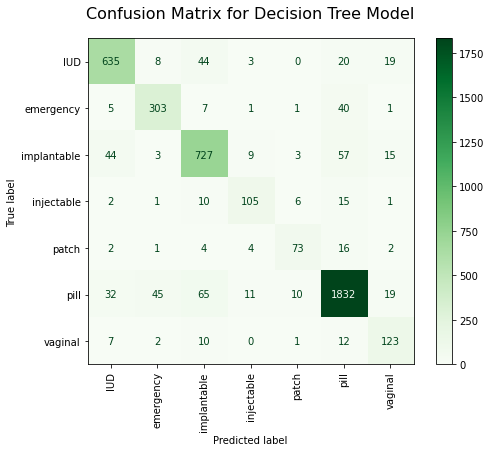

CPU times: user 1min 23s, sys: 1.51 s, total: 1min 24s
Wall time: 1min 25s


In [16]:
%%time

run_model_1(DecisionTreeClassifier(random_state=SEED), 'Decision Tree')

## Tuning the decision tree model

In [17]:
%%time

if do_grids == True:
    best_params_ = tune_model_1(DecisionTreeClassifier(random_state=SEED), param_grid={
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [10, 20, None],
        'model__min_samples_leaf': [1, 2, 3]
    })
else:
    best_params_ = "{'model__criterion': 'gini', 'model__max_depth': 20, 'model__min_samples_leaf': 1}"
print(best_params_)

{'model__criterion': 'gini', 'model__max_depth': 20, 'model__min_samples_leaf': 1}
CPU times: user 138 µs, sys: 56 µs, total: 194 µs
Wall time: 150 µs


## Decision tree — tuned

Training Score: 0.9483     
Test Score:     0.8827

Accuracy Score: 0.8827
F1 Macro Score: 0.835


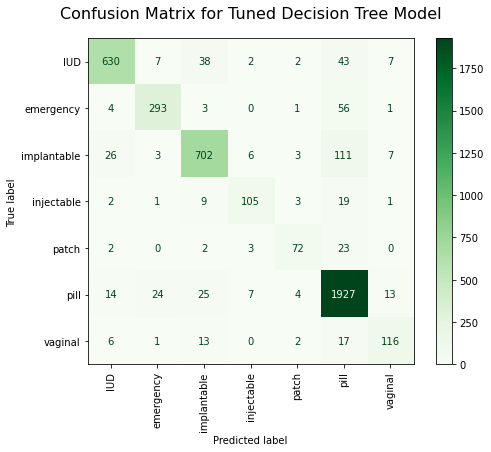

CPU times: user 56.8 s, sys: 1 s, total: 57.8 s
Wall time: 57.8 s


In [18]:
%%time

run_model_1(DecisionTreeClassifier(
    random_state=SEED,
    criterion='gini',
    max_depth=20,
    min_samples_leaf=1
),
           'Tuned Decision Tree'
           )

## Random forest

Training Score: 0.9999     
Test Score:     0.8329

Accuracy Score: 0.8329
F1 Macro Score: 0.5899


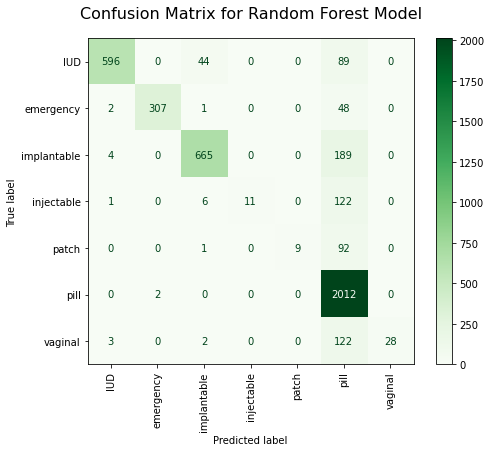

CPU times: user 4min 17s, sys: 1.93 s, total: 4min 19s
Wall time: 4min 20s


In [19]:
%%time

run_model_1(RandomForestClassifier(random_state=SEED), 'Random Forest')

## Tuning the random forest model

In [20]:
%%time

if do_grids == True:
    best_params_ = tune_model_1(RandomForestClassifier(random_state=SEED), param_grid={
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [10, 20, None],
        'model__min_samples_leaf': [1, 2, 3]
    })
else:
    best_params_ = "{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1}"
print(best_params_)

{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1}
CPU times: user 378 µs, sys: 402 µs, total: 780 µs
Wall time: 449 µs


## Random forest — tuned

Training Score: 0.9999     
Test Score:     0.8329

Accuracy Score: 0.8329
F1 Macro Score: 0.5899


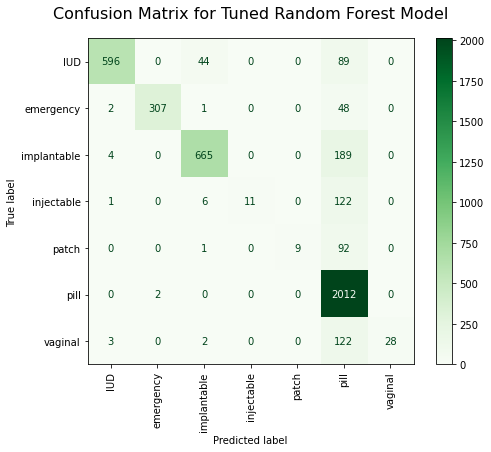

CPU times: user 4min 18s, sys: 1.95 s, total: 4min 20s
Wall time: 4min 21s


In [21]:
%%time

run_model_1(RandomForestClassifier(
    random_state=SEED,
    criterion='gini',
    max_depth=None,
    min_samples_leaf=1
),
           'Tuned Random Forest'
           )

## Logistic regression

Training Score: 0.9504     
Test Score:     0.9213

Accuracy Score: 0.9213
F1 Macro Score: 0.8662


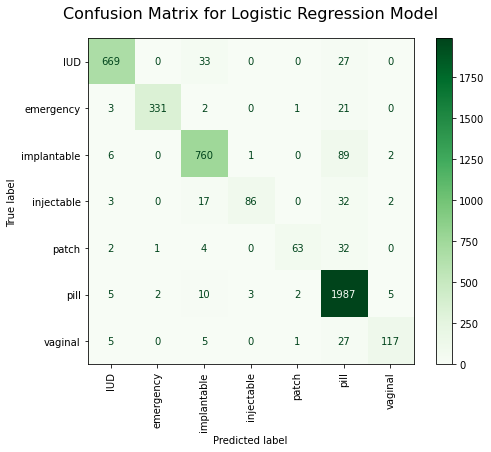

CPU times: user 10min 57s, sys: 2min 17s, total: 13min 14s
Wall time: 5min 36s


In [22]:
%%time

run_model_1(LogisticRegression(random_state=SEED, max_iter=1000), 'Logistic Regression')

## Tuning the logistic regression model

In [ ]:
%%time

if do_grids == True:
    best_params_ = tune_model_1(LogisticRegression(random_state=SEED, max_iter=1000), param_grid={
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
        'model__penalty': ['l1', 'l2'],  # Regularization penalty ('l1' for Lasso, 'l2' for Ridge)
        'model__solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
    })
else:
    best_params_ = "{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}"
print(best_params_)

## Logistic regression — tuned

Training Score: 0.9985     
Test Score:     0.9417

Accuracy Score: 0.9417
F1 Macro Score: 0.9045


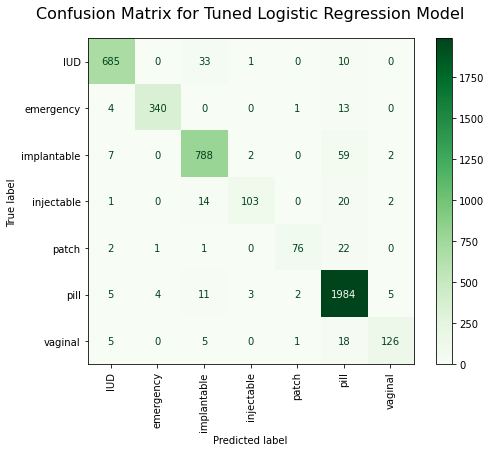

CPU times: user 4min 44s, sys: 1min 22s, total: 6min 6s
Wall time: 1min 47s


In [23]:
%%time

run_model_1(LogisticRegression(
    random_state=SEED,
    max_iter=1000,
    C=10,
    penalty='l2',
    solver='liblinear'
),
           'Tuned Logistic Regression'
           )

## Bagged trees

Training Score: 0.9923     
Test Score:     0.9079

Accuracy Score: 0.9079
F1 Macro Score: 0.8654


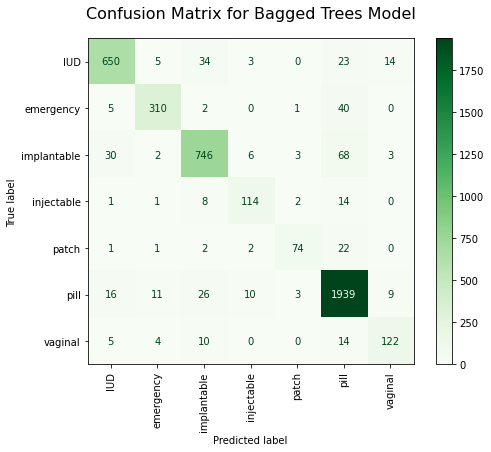

CPU times: user 7min 44s, sys: 1.83 s, total: 7min 46s
Wall time: 7min 47s


In [24]:
%%time

run_model_1(BaggingClassifier(random_state=SEED), 'Bagged Trees')

## Tuning the bagged trees model

In [ ]:
%%time

if do_grids == True:
    best_params_ = tune_model_1(BaggingClassifier(random_state=SEED, estimator=DecisionTreeClassifier()), param_grid={
        'model__n_estimators': [10, 50, 100],  # Number of base estimators (decision trees in this case)
        'model__max_samples': [0.5, 0.7, 1.0],  # Sample size for each base estimator
        'model__max_features': [0.5, 0.7, 1.0]  # Number of features to consider for each base estimator
    })
else:
    best_params_ = "{'model__max_features': 0.7, 'model__max_samples': 1.0, 'model__n_estimators': 100}"
print(best_params_)

## Bagged trees — tuned

In [ ]:
%%time

run_model_1(BaggingClassifier(
    random_state=SEED,
    max_features=0.7,
    max_samples=1.0,
    n_estimators=100
),
           'Tuned Bagged Trees'
           )

## XGBoost

In [ ]:
%%time

run_model_1(XGBClassifier(
    random_state=SEED
),
           'XGBoost'
           )

Waiting on Bagged Trees - tuned and XGBoost ...

- Decision Tree: F1 0.82 || Acc 87%
- ... Tuned: F1: 0.84 || Acc 88%
- Random Forest: F1 0.59 || Acc 83%
- ... Tuned: F1 0.59 || Acc 83%
- Logistic Regression: F1 0.87 || 92%
- **... Tuned: F1 0.90 || Acc 94%**
- Bagged Trees: F1 0.87 || Acc 91%
- ... Tuned: ???
- XGBoost: ??? (was earlier 94% accuracy)

## Predicting rating

## The target feature

In [ ]:
rating_threshold = [2, 10]

print(len(df[df.rating <= rating_threshold[0]]), len(df[df.rating >= rating_threshold[1]]))

The above would be the easiest split. It uses fewer values and reduces class imbalance.

In [ ]:
rating_threshold = [7, 8]

neg_count = len(df[df.rating <= rating_threshold[0]])
pos_count = len(df[df.rating >= rating_threshold[1]])

print(neg_count, pos_count)

The above would be the best way to reduce class imbalance while using all of the data.

In [ ]:
rating_threshold = [4, 6]

neg_count = len(df[df.rating <= rating_threshold[0]])
pos_count = len(df[df.rating >= rating_threshold[1]])

print(neg_count, pos_count)

The above would use nearly all the data and give a better approximation of positive v. negative. It introduces a more significant class imbalance, though.

In [ ]:
neg_freq = neg_count / (neg_count + pos_count)
pos_freq = pos_count / (neg_count + pos_count)

In [ ]:
df.drop(df[
    (df.rating > rating_threshold[0]) & \
    (df.rating < rating_threshold[1])
].index, inplace=True)

df['target'] = df.rating.apply(lambda x: 1 if x <= rating_threshold[0] else 0)

In [ ]:
X_train, X_test, y_train, y_test = \
train_test_split(df[['review'] + engineered_features], df['target'], test_size=0.2, random_state=SEED)

In [ ]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[1],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

## Discuss metric

## Preprocess data

In [ ]:
# reset variables

text_preprocessor = None
numerical_preprocessor = None
preprocessor = None
pipeline = None
accuracy = None
feature_names = None
coefficients = None
decision_function_values = None
importance_df = None
feature_importance = None

In [ ]:
max_features = None
stop_words = stop_list_light
ngram_range = (1,3)
class_weight = {
    0: neg_freq,
    1: pos_freq/neg_freq
}

In [ ]:
text_preprocessor = TfidfVectorizer(
    max_features=max_features,
    ngram_range=ngram_range
)

numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_preprocessor, 'review'),
        ('numerical', numerical_preprocessor, engineered_features)
    ]
)

In [ ]:
def run_model_2(model, title):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    # generate predictions for the test data
    y_pred = pipeline.predict(X_test)
    # display the training and test accuracy scores
    print(f"Training Score: {round(pipeline.score(X_train, y_train),4)} \
    \nTest Score:     {round(pipeline.score(X_test, y_test),4)}")
    
    # generate predictions for the test data
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for log loss
    
    # calculate different evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # display different evaluation metrics
    print(f"\nAccuracy Score: {round(accuracy, 4)}")
    print(f"Recall Score: {round(recall, 4)}")
    print(f"F1 Score: {round(f1, 4)}")
    print(f"ROC-AUC Score: {round(roc_auc, 4)}")
    
    # plot the normalized confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    fig, ax = plt.subplots(figsize=(8, 6))  # Modify the figsize as per your preference
    disp.plot(cmap='Greens', ax=ax)
    plt.title(f"Confusion Matrix for {title} Model", fontsize=16, pad=20)
    plt.xticks(rotation=90)
    plt.show()
    
    

    # Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calculate the Area Under the ROC Curve (ROC-AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guessing')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f"ROC Curve for {title} Model", fontsize=16, pad=20)
    plt.legend(loc='lower right')
    plt.show()

    
    feature_names = preprocessor.named_transformers_['text'].get_feature_names_out().tolist() + engineered_features
    
    n_features = 25

    # --------------------------------------------------------
    if hasattr(model, 'feature_importances_'):
        coefficients = model.feature_importances_
    elif hasattr(model.coef_, 'toarray'):
        coefficients = model.coef_.toarray().flatten()
    elif hasattr(model, 'coef_'):
        coefficients = model.coef_.flatten()
    else:
        return
    # --------------------------------------------------------

    importance_df = pd.DataFrame(feature_names, columns=['Word'])
    importance_df['Importance'] = np.e**(abs(coefficients))
    importance_df['Coefficient'] = coefficients

    feature_importance = importance_df.sort_values(
        by = ["Importance"], ascending=False
    ).head(n_features)

    fig, ax = plt.subplots(figsize=(15,10), ncols=2)
    ax[0].set_title(f'Coefficients for {title} Model')
    ax[0].set_ylabel('Word')
    ax[0].set_xlabel('Coefficient')
    sns.barplot(x='Coefficient', y='Word', data=feature_importance, 
                palette='coolwarm', ax=ax[0])
    #plotting feature importances
    ax[1].set_title(f'Feature Importances for {title} Model')
    ax[1].set_ylabel('Word')
    ax[1].set_xlabel('Importance')
    sns.barplot(x='Importance', y='Word', data=feature_importance, 
                palette='coolwarm', ax=ax[1])
    plt.tight_layout()
    




In [ ]:
def tune_model_2(model, param_grid):
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    param_grid = param_grid
    gridsearch = GridSearchCV(
        estimator=pipeline,
        param_grid = param_grid,
        cv=5,
        scoring='roc_auc',
    )
    gridsearch.fit(X_train,  y_train)
    gridsearch.best_params_
    return gridsearch.best_params_

## Decision tree

In [ ]:
%%time

run_model_2(
    DecisionTreeClassifier(random_state=SEED, class_weight=class_weight),
    'Decision Tree'
)

## Tuning the decision tree model

In [ ]:
%%time

if do_grids == True:
    best_params_ = tune_model_2(DecisionTreeClassifier(random_state=SEED, class_weight=class_weight), param_grid={
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [10, 20, None],
        'model__min_samples_leaf': [1, 2, 3]
    })
else:
    best_params_ = "{'model__criterion': 'gini', 'model__max_depth': 20, 'model__min_samples_leaf': 2}"
print(best_params_)

## Decision tree — tuned

In [ ]:
%%time

run_model_2(DecisionTreeClassifier(
    random_state=SEED,
    class_weight=class_weight,
    criterion='gini',
    max_depth=20,
    min_samples_leaf=2
),
           'Tuned Decision Tree'
           )

## Random forest

In [ ]:
%%time

run_model_2(
    RandomForestClassifier(random_state=SEED, class_weight=class_weight),
    'Random Forest'
)

## Tuning the random forest model

In [ ]:
%%time

if do_grids == True:
    best_params_ = tune_model_2(RandomForestClassifier(random_state=SEED, class_weight=class_weight), param_grid={
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [10, 20, None],
        'model__min_samples_leaf': [1, 2, 3]
    })
else:
    best_params_ = "{'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1}"
print(best_params_)

## Random forest — tuned

In [ ]:
%%time

run_model_2(RandomForestClassifier(
    random_state=SEED,
    class_weight=class_weight,
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=1
),
           'Tuned Random Forest'
           )

## Logistic regression

In [ ]:
%%time

run_model_2(
    LogisticRegression(random_state=SEED, class_weight=class_weight, max_iter=1000),
    'Logistic Regression'
)

## Tuning the logistic regression model

## Logistic regression — tuned

In [ ]:
%%time

run_model_2(LogisticRegression(
    random_state=SEED,
    class_weight=class_weight,
    max_iter=1000,
    C=10,
    penalty='l2',
    solver='liblinear'
),
           'Tuned Logistic Regression'
           )

## XGBoost

In [ ]:
%%time

run_model_2(
    XGBClassifier(random_state=SEED, class_weight=class_weight),
    'XGBoost'
)

- Decision Tree: ROC-AUC 0.69 || Rec 55% || Acc 73%
- ... Tuned: ROC-AUC 0.75 || Rec 80% || Acc 71%
- Random Forest: ROC-AUC 0.91 || Rec 61% || Acc 82%
- ... Tuned: ROC-AUC 0.93 || Rec 63% || Acc 83%
- Logistic Regression: ROC-AUC 0.93 || Rec 96% || Acc 77%
- **... Tuned: ROC-AUC 0.95 || Rec 91% || Acc 86%**
- XGBoost: ROC-AUC 0.92 || Rec 75% || Acc 85%

# Evaluation

# Recommendations

Don't know where else to put this right now. At least one review, 27228, is glowingly positive but gave a 1.0 rating, clearly misunderstanding the rating system.

- Don't sleep on the patch. Women feel strongly about it, and they like that it makes their breasts larger.

## Use a different rating system

No more than 5 points.

# Further Inquiry

- Recommendation algorithm
- ~~word count~~
- ~~character count~~
- ~~words in all caps~~
- ~~average word length~~
- whether words are in English (spelled correctly)
- ~~whether it includes characters such as exclamation points, question marks~~
- (especially repeatedly), and emoticons
- ~~whether it mentions the brand~~
- or generic name in the review
- whether it uses slang versus technical language
- whether it mentions touchy subjects such as abortion
- ngrams
- does it mention switching treatments, comparison to other methods
- ~~"but" count~~
- features that indicate whether certain side effects are discussed, e.g. weight gain, acne

In [ ]:
if light_frame == False:
    filepath = Path('../data/preprocessed.csv')
    filepath.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filepath)

In [ ]:
%store engineered_features